### This is the most up to date classifier, with everything from transfer_classifier_resnet_multi.ipynb being moved to here and cleaned up. The full execution of this notebook will generate a new model and save the file path, so it is recommended that you change the `model_name` variable so that the current model is not overwritten

In [1]:
import sys
sys.path.append("../../src")

In [3]:
import os
import tempfile
import time
import pickle as pkl;

import numpy as np
import matplotlib.pyplot as plt;

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

from PIL import Image
from sklearn.metrics import roc_auc_score

from util.train_methods import (GetLoader,
                                load_old_weights,
                                hard_binary_accuracy,
                                train,
                                test,
                                display_roc_curve)

In /usr/remote/anaconda-3.7-2020-05-28/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /usr/remote/anaconda-3.7-2020-05-28/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /usr/remote/anaconda-3.7-2020-05-28/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /usr/remote/anaconda-3.7-2020-05-28/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /usr/

## Parameters

In [4]:
n_epochs = 50
patience_limit = 20
patience = 0
batch_size_train = 16# was 64
batch_size_test = 16
learning_rate = 0.0005
log_interval = 31
tt_factor = 0.8
orientation = 'AP'
num_imgs = 5000
retrain_old_model = False

model_name = 'bbox_disease_classifier'
model_path = '../saved_models/' + model_name + '.pth'

random_seed = 1
torch.manual_seed(random_seed)

In [5]:
''' 
    NOTES: 
    - it's "No Finding" not "No findings"
    - it's "Pleural_Thickening" not "Pleural_thickening"
    - it's not "Nodule Mass", but rather "Nodule" and "Mass" separately
'''
disease_map = {"Atelectasis" : 0, "Consolidation" : 1, "Infiltration" : 2, "Pneumothorax": 3, "Edema": 4,
               "Emphysema": 5, "Fibrosis": 6, "Effusion" : 7, "Pneumonia" : 8, "Pleural_Thickening" : 9,
               "Cardiomegaly" : 10, "Nodule" : 11, "Mass" : 12, "Hernia" : 13, "No Finding" : 14 }

dis_small_map = {'Cardiomegaly': 0, 'Effusion': 1, 'Mass': 2, 'Nodule': 3,
                 'Atelectasis': 4, 'Infiltration': 5, 'Pneumonia' : 6, 'Pneumothorax' : 7, 'No Finding': 8}

### Load in dataset

In [6]:
pkl_load = open('../data/dataset.pickle', 'rb')
data = pkl.load(pkl_load)
pkl_load.close()
print("data loaded in successfully")

data loaded in successfully


In [7]:
transforms = [torchvision.transforms.RandomHorizontalFlip(p=0.5),
              torchvision.transforms.CenterCrop(1000), # removing edges since model sometimes learns weird edge features
              torchvision.transforms.RandomRotation(5),              
              torchvision.transforms.ToTensor()]

dataset_train = GetLoader(data, orientation, list(dis_small_map.keys()),
                          num_imgs, tt_factor, 'train', transforms)
dataset_valid = GetLoader(data, orientation, list(dis_small_map.keys()),
                          num_imgs, tt_factor, 'test', transforms)
dataset_test = GetLoader(data, orientation, list(dis_small_map.keys()),
                          num_imgs, tt_factor, 'valid', transforms)
print('train imgs:', len(dataset_train))
print('test imgs:', len(dataset_valid))
print('valid imgs:', len(dataset_test))

train imgs: 31364
test imgs: 3921
valid imgs: 3920


In [8]:
train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size_train, shuffle=True, num_workers=1)
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size_test, shuffle=True, num_workers=1)
valid_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size_test, shuffle=True, num_workers=1)
print('train batches:', len(dataset_train))
print('test batches:', len(dataset_valid))
print('valid batches:', len(dataset_test))

train batches: 31364
test batches: 3921
valid batches: 3920


In [9]:
network = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=False)

network.fc = nn.Sequential(*[
    nn.Linear(in_features=512, out_features=9, bias=True),
    nn.Sigmoid(),
])

network = torch.nn.DataParallel(network)
network.cuda();

Using cache found in /home/npp002/.cache/torch/hub/pytorch_vision_v0.6.0


In [10]:
if retrain_old_model:
    load_old_weights(network, model_path)

In [11]:
optimizer = optim.Adam(network.parameters(), lr=learning_rate)
print('Trainable params: {}'.format(sum(p.numel() for p in network.parameters() if p.requires_grad)))

Trainable params: 11181129


In [12]:
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))
print(torch.cuda.is_available())

1
GeForce RTX 2080 Ti
True


Starting Training...
-----------Epoch 1 (time = 1163.69 s  aka   19.39  mins) ----------------
Train set: Avg. loss: 0.0278,  Accuracy: 231290/282276 (81.94%)
Test set:  Avg. loss: 0.0282, Accuracy: 28461/35280 (80.67%)

Epoch 1 --- saving new best model: test loss = 0.02823363915846056



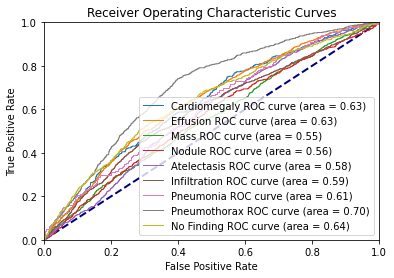

-----------Epoch 2 (time = 1082.01 s  aka   18.03  mins) ----------------
Train set: Avg. loss: 0.0275,  Accuracy: 231337/282276 (81.95%)
Test set:  Avg. loss: 0.0284, Accuracy: 28625/35280 (81.14%)

-----------Epoch 3 (time = 1057.74 s  aka   17.63  mins) ----------------
Train set: Avg. loss: 0.0275,  Accuracy: 231340/282276 (81.96%)
Test set:  Avg. loss: 0.0299, Accuracy: 27863/35280 (78.98%)

-----------Epoch 4 (time = 1056.64 s  aka   17.61  mins) ----------------
Train set: Avg. loss: 0.0275,  Accuracy: 231348/282276 (81.96%)
Test set:  Avg. loss: 0.0278, Accuracy: 28562/35280 (80.96%)

Epoch 4 --- saving new best model: test loss = 0.02782377666052507

-----------Epoch 5 (time = 1042.63 s  aka   17.38  mins) ----------------
Train set: Avg. loss: 0.0273,  Accuracy: 231390/282276 (81.97%)
Test set:  Avg. loss: 0.0284, Accuracy: 28452/35280 (80.65%)

-----------Epoch 6 (time = 1049.49 s  aka   17.49  mins) ----------------
Train set: Avg. loss: 0.0273,  Accuracy: 231419/282276 (81

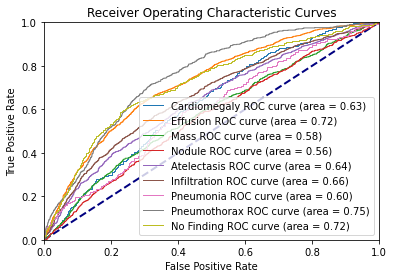

-----------Epoch 11 (time = 1028.71 s  aka   17.15  mins) ----------------
Train set: Avg. loss: 0.0267,  Accuracy: 231923/282276 (82.16%)
Test set:  Avg. loss: 0.0271, Accuracy: 28687/35280 (81.31%)

Epoch 11 --- saving new best model: test loss = 0.027109551262490605

-----------Epoch 12 (time = 1058.32 s  aka   17.64  mins) ----------------
Train set: Avg. loss: 0.0263,  Accuracy: 232278/282276 (82.29%)
Test set:  Avg. loss: 0.0275, Accuracy: 28701/35280 (81.35%)

-----------Epoch 13 (time = 1064.49 s  aka   17.74  mins) ----------------
Train set: Avg. loss: 0.0263,  Accuracy: 232315/282276 (82.30%)
Test set:  Avg. loss: 0.0270, Accuracy: 28624/35280 (81.13%)

Epoch 13 --- saving new best model: test loss = 0.027011314612262104

-----------Epoch 14 (time = 1033.66 s  aka   17.23  mins) ----------------
Train set: Avg. loss: 0.0259,  Accuracy: 232758/282276 (82.46%)
Test set:  Avg. loss: 0.0262, Accuracy: 28853/35280 (81.78%)

Epoch 14 --- saving new best model: test loss = 0.026201

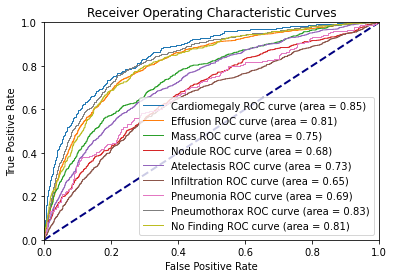

-----------Epoch 21 (time = 1016.3 s  aka   16.94  mins) ----------------
Train set: Avg. loss: 0.0239,  Accuracy: 236202/282276 (83.68%)
Test set:  Avg. loss: 0.0257, Accuracy: 28911/35280 (81.95%)

Epoch 21 --- saving new best model: test loss = 0.02573563968192558

-----------Epoch 22 (time = 1014.66 s  aka   16.91  mins) ----------------
Train set: Avg. loss: 0.0236,  Accuracy: 236630/282276 (83.83%)
Test set:  Avg. loss: 0.0247, Accuracy: 29290/35280 (83.02%)

Epoch 22 --- saving new best model: test loss = 0.024730262662075005

-----------Epoch 23 (time = 1015.71 s  aka   16.93  mins) ----------------
Train set: Avg. loss: 0.0233,  Accuracy: 237114/282276 (84.00%)
Test set:  Avg. loss: 0.0245, Accuracy: 29358/35280 (83.21%)

Epoch 23 --- saving new best model: test loss = 0.024521738731739472

-----------Epoch 24 (time = 1015.28 s  aka   16.92  mins) ----------------
Train set: Avg. loss: 0.0231,  Accuracy: 237749/282276 (84.23%)
Test set:  Avg. loss: 0.0247, Accuracy: 29221/3528

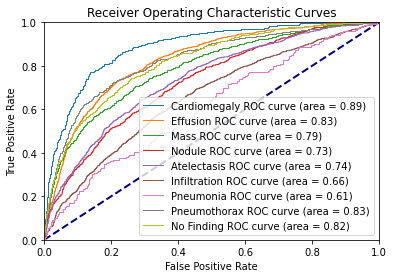

-----------Epoch 31 (time = 1020.53 s  aka   17.01  mins) ----------------
Train set: Avg. loss: 0.0212,  Accuracy: 241256/282276 (85.47%)
Test set:  Avg. loss: 0.0246, Accuracy: 29367/35280 (83.24%)

Epoch 31 --- saving new best model: test loss = 0.024569052032061986

-----------Epoch 32 (time = 1020.95 s  aka   17.02  mins) ----------------
Train set: Avg. loss: 0.0208,  Accuracy: 242287/282276 (85.83%)
Test set:  Avg. loss: 0.0241, Accuracy: 29537/35280 (83.72%)

Epoch 32 --- saving new best model: test loss = 0.0240899600240649

-----------Epoch 33 (time = 1021.8 s  aka   17.03  mins) ----------------
Train set: Avg. loss: 0.0205,  Accuracy: 242739/282276 (85.99%)
Test set:  Avg. loss: 0.0236, Accuracy: 29572/35280 (83.82%)

Epoch 33 --- saving new best model: test loss = 0.02364383688842764

-----------Epoch 34 (time = 1019.69 s  aka   16.99  mins) ----------------
Train set: Avg. loss: 0.0201,  Accuracy: 243574/282276 (86.29%)
Test set:  Avg. loss: 0.0249, Accuracy: 29422/35280 

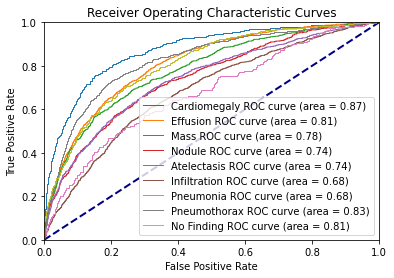

-----------Epoch 41 (time = 1018.63 s  aka   16.98  mins) ----------------
Train set: Avg. loss: 0.0167,  Accuracy: 250749/282276 (88.83%)
Test set:  Avg. loss: 0.0258, Accuracy: 29260/35280 (82.94%)

Epoch 41 --- saving new best model: test loss = 0.025821394328864253

-----------Epoch 42 (time = 1018.89 s  aka   16.98  mins) ----------------
Train set: Avg. loss: 0.0160,  Accuracy: 251862/282276 (89.23%)
Test set:  Avg. loss: 0.0278, Accuracy: 28911/35280 (81.95%)

Epoch 42 --- saving new best model: test loss = 0.027803976267424164

-----------Epoch 43 (time = 1018.87 s  aka   16.98  mins) ----------------
Train set: Avg. loss: 0.0154,  Accuracy: 253244/282276 (89.72%)
Test set:  Avg. loss: 0.0274, Accuracy: 29444/35280 (83.46%)

Epoch 43 --- saving new best model: test loss = 0.02736009119496662

-----------Epoch 44 (time = 1018.91 s  aka   16.98  mins) ----------------
Train set: Avg. loss: 0.0149,  Accuracy: 254521/282276 (90.17%)
Test set:  Avg. loss: 0.0295, Accuracy: 29072/352

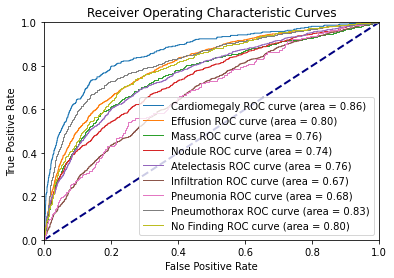

Reloading best model from epoch 50
Training complete (time = 52409.44 s)
Saved model to ../saved_models/bbox_disease_classifier.pth


In [13]:
print("Starting Training...")
begin_time = time.time()

min_loss_test = 999

train_losses = []
test_losses = []

train_acc = []
test_acc = []

train_true_pos = []
train_false_pos = []
train_true_neg = []
train_false_neg = []

test_true_pos = []
test_false_pos = []
test_true_neg = []
test_false_neg = []

best_model_file = tempfile.NamedTemporaryFile(mode='w+b', delete=False)
torch.save(network.state_dict(), best_model_file.name)



for epoch in range(1, n_epochs + 1):
    start_time = time.time()
    network.load_state_dict(torch.load(best_model_file.name))

    loss_train, true_pos_train, false_pos_train, true_neg_train, false_neg_train = train(epoch,
                                                                                         network,
                                                                                         train_loader,
                                                                                         optimizer,
                                                                                         batch_size_train)
    loss_test, true_pos_test, false_pos_test, true_neg_test, false_neg_test = test(network,
                                                                                   test_loader,
                                                                                   batch_size_test)
    
    train_losses.append(loss_train)
    test_losses.append(loss_test)
    
    n_correct_train = true_pos_train + true_neg_train
    n_correct_test = true_pos_test + true_neg_test
    
    acc_train = 100. * n_correct_train / (n_correct_train + false_pos_train + false_neg_train)
    acc_test = 100. * n_correct_test / (n_correct_test + false_pos_test + false_neg_test)
    
    train_acc.append(acc_train)
    test_acc.append(acc_test)
    
    train_true_pos.append(true_pos_train)
    train_false_pos.append(false_pos_train)
    train_true_neg.append(true_neg_train)
    train_false_neg.append(false_neg_train)

    test_true_pos.append(true_pos_test)
    test_false_pos.append(false_pos_test)
    test_true_neg.append(true_neg_test)
    test_false_neg.append(false_neg_test)
        
    auc_train = roc_auc_score

        
    elapsed_time = time.time() - start_time
    
    print("-----------Epoch " + str(epoch) + " (time =", round(elapsed_time, 2), "s  aka  ", round(elapsed_time / 60, 2), " mins) ----------------")
    print('Train set: Avg. loss: {:.4f},  Accuracy: {}/{} ({:.2f}%)'.format(
        loss_train, n_correct_train, (n_correct_train + false_pos_train + false_neg_train), acc_train))
 
    print('Test set:  Avg. loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        loss_test, n_correct_test, (n_correct_test + false_pos_test + false_neg_test), acc_test))    
    
    if loss_test < min_loss_test or (epoch > 20 and loss_test < min_loss_test * 1.2):
        min_loss_test = loss_test
        patience = 0
        best_epoch = epoch
        
        print('Epoch {} --- saving new best model: test loss = {}\n'.format(epoch, loss_test))
        torch.save(network.state_dict(), best_model_file.name)
        torch.save(network.state_dict(), os.path.join(model_path)) # guarantees best one saved if program crashes
    else:
        patience += 1
        
    if patience == patience_limit:
        print('Breaking on patience={}'.format(patience))
        break
        
    if epoch % 10 == 0 or epoch == 1:
        display_roc_curve(valid_loader, network, dis_small_map, batch_size_test)
        

print('Reloading best model from epoch {}'.format(best_epoch))
network.load_state_dict(torch.load(best_model_file.name))

end_time = time.time() - begin_time

print("Training complete (time =", round(end_time, 2), "s)")
torch.save(network.state_dict(), 
           os.path.join(model_path))
print("Saved model to {}".format(model_path))

    

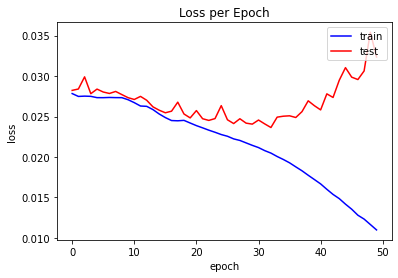

In [14]:
import matplotlib.pyplot as plt

plt.figure()
plt.title("Loss per Epoch")
plt.plot(train_losses, "-b",  label="train")
plt.plot(test_losses, "-r", label="test")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc="upper right")

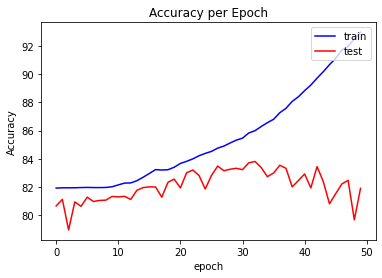

In [15]:
import matplotlib.pyplot as plt

plt.figure()
plt.title("Accuracy per Epoch")
plt.plot(train_acc, "-b", label="train")
plt.plot(test_acc, "-r", label="test")
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.legend(loc="upper right")

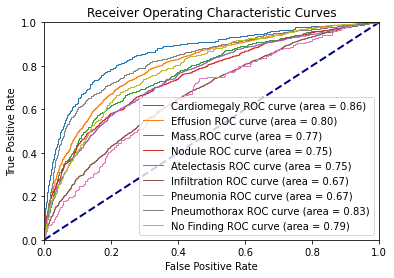

In [16]:
display_roc_curve(valid_loader, network, dis_small_map, batch_size_test)